Highlighter

In [1]:
!pip install scikit-learn torch pandas transformers matplotlib

In [1]:
from highlight import HighlightHead
from helper import HighlightHelper
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from transformers import get_linear_schedule_with_warmup

model_name = 'google/electra-base-generator'

helper = HighlightHelper(model_name=model_name)
model = HighlightHead(outdim=4, hidden_size=helper.config.hidden_size, model_name=model_name, kernel_size=5)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

df = pd.read_pickle("highlights.pkl")
sentences_df = pd.read_pickle("sentences.pkl")

x_train, x_test, y_train, y_test = train_test_split(df.iloc[:, [0, 1]], df.iloc[:, 2], test_size=0.20, random_state=111)
x_traiin, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=222)

epochs = 10

train_df = pd.concat([x_train, y_train], axis=1)
test_df = pd.concat([x_test, y_test], axis=1)
valid_df = pd.concat([x_val, y_val], axis=1)

df_0 = train_df[train_df.iloc[:, 2] == 0]
df_1 = train_df[train_df.iloc[:, 2] == 1]
df_2 = train_df[train_df.iloc[:, 2] == 2]
df_3 = train_df[train_df.iloc[:, 2] == 3]

sample_num = len(train_df)//4
df_0 = resample(df_0, replace=True, n_samples=sample_num, random_state=333)
df_1 = resample(df_1, replace=True, n_samples=sample_num, random_state=444)
df_2 = resample(df_2, replace=True, n_samples=sample_num, random_state=555)
df_3 = resample(df_3, replace=True, n_samples=sample_num, random_state=666)

train_df = pd.concat([df_0, df_1, df_2, df_3], axis=0)
train_df = train_df.sample(frac=1, random_state=777).reset_index(drop=True)

no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]

head_parameters = [param for name, param in list(model.named_parameters()) if "model" not in name and "conv" not in name]
encoder_wd_parameters = [param for name, param in list(model.named_parameters()) if "model" in name and not any(nd in name for nd in no_decay)]
encoder_nowd_parameters = [param for name, param in list(model.named_parameters()) if "model" in name and any(nd in name for nd in no_decay)]

parameters = [
    {'params': head_parameters, 'weight_decay': 0.0, 'lr': 3e-5},
    {'params': encoder_wd_parameters, 'weight_decay': 5e-2, 'lr': 2e-5},
    {'params': encoder_nowd_parameters, 'weight_decay': 0.0, 'lr': 2e-5},
]

optimizer = torch.optim.AdamW(parameters)

scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=epochs)

for param in model.model.parameters():
    param.requires_grad = False

/home/jadenyou/highlighter/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jadenyou/highlighter/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [2]:
from tqdm import tqdm

total_loss = 0
total_runs = 0
loss_at_each = []

for epoch in range(epochs):
    
    #training
    model.train()
    for index, item in tqdm(train_df.iterrows(), total=len(train_df)):
        optimizer.zero_grad()
        sentence = sentences_df.iloc[item.iloc[0][0]][0]
        index = item.iloc[0][1]
        tag = item.iloc[2]
        texts, highlights, mask = helper.split_mask(
            text=sentence,
            index=index,
            highlight=tag,
            device=device
        )
        guess, loss = model(texts, highlights, mask)
        # print(torch.exp(guess))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_runs += 1
        loss_at_each.append(loss.item())
    
    scheduler.step()
    
    #unfreeze parameters
    if epoch == 2:
        for param in model.model.parameters():
            param.requires_grad = True
            
    # evaluation
    model.eval()
    total_samples = 0
    total_correct = 0
    with torch.no_grad():
        for index, item in tqdm(valid_df.iterrows(), total=len(valid_df)):
            sentence = sentences_df.iloc[item.iloc[0][0]][0]
            index = item.iloc[0][1]
            tag = item.iloc[2]
            texts, highlights, mask = helper.split_mask(
                text=sentence,
                index=index,
                highlight=tag,
                device=device
            )
            guess, loss = model(texts, highlights, mask)
            guess = torch.exp(guess).argmax(dim=1).squeeze()
            for j in range(len(mask)):
                if (mask[j] == 1):
                    total_samples += 1
                    if guess[j] == tag:
                        total_correct += 1
                        
    print("Validation Accuracy: ", total_correct/total_samples)
    
    print("Loss: ", total_loss/total_runs)
    total_loss = 0
    total_runs = 0

model.save("model.pt")

100%|██████████| 872/872 [00:06<00:00, 133.77it/s]


Validation Accuracy:  0.3187702265372168
Loss:  1.363064759104041


100%|██████████| 872/872 [00:06<00:00, 138.94it/s]


Validation Accuracy:  0.3454692556634304
Loss:  1.299812487000439


100%|██████████| 872/872 [00:06<00:00, 139.43it/s]


Validation Accuracy:  0.36326860841423947
Loss:  1.2523035627162142


100%|██████████| 872/872 [00:06<00:00, 136.53it/s]


Validation Accuracy:  0.6868932038834952
Loss:  0.6856887516114929


100%|██████████| 872/872 [00:06<00:00, 138.01it/s]


Validation Accuracy:  0.7305825242718447
Loss:  0.368165525111095


100%|██████████| 872/872 [00:06<00:00, 137.02it/s]


Validation Accuracy:  0.7330097087378641
Loss:  0.29093699819107893


100%|██████████| 872/872 [00:06<00:00, 136.18it/s]


Validation Accuracy:  0.7394822006472492
Loss:  0.25181320002642016


100%|██████████| 872/872 [00:06<00:00, 138.29it/s]


Validation Accuracy:  0.7370550161812298
Loss:  0.22836894533411417


100%|██████████| 872/872 [00:06<00:00, 134.98it/s]


Validation Accuracy:  0.7273462783171522
Loss:  0.21083722729108914


100%|██████████| 872/872 [00:06<00:00, 137.76it/s]


Validation Accuracy:  0.732200647249191
Loss:  0.19176960226424236


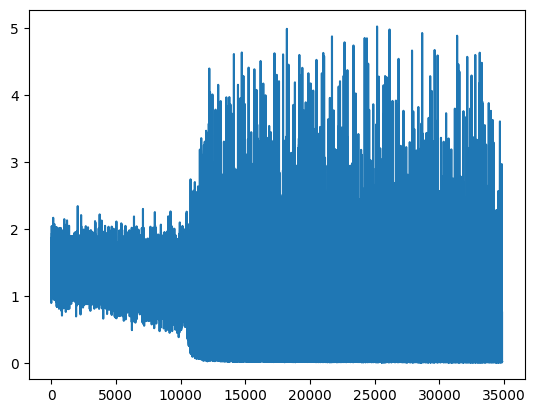

In [3]:
import matplotlib.pyplot as plt

plt.plot(loss_at_each)
plt.show()

In [4]:
total_correct = 0
total_samples = 0

model.load_state_dict(torch.load("model.pt"))
model.eval()

correct_each = [0, 0, 0, 0]
total_each = [0, 0, 0, 0]

for index, item in tqdm(test_df.iterrows(), total=len(test_df)):
    sentence = sentences_df.iloc[item.iloc[0][0]][0]
    index = item.iloc[0][1]
    tag = item.iloc[2]
    texts, highlights, mask = helper.split_mask(
        text=sentence,
        index=index,
        highlight=tag,
        device=device
    )
    guess, loss = model(texts, highlights, mask)
    guess = torch.exp(guess).argmax(dim=1)
    mask = mask.squeeze()
    for j in range(len(mask)):
        if (mask[j] == 1):
          total_samples += 1
          total_each[tag] += 1
          if guess[j] == tag:
            total_correct += 1
            correct_each[tag] += 1

 59%|█████▉    | 517/872 [00:14<00:10, 35.32it/s]

In [ ]:
print("Total accuracy (micro-average): ", total_correct/total_samples)
accuracy_by_tag = [correct_each[i]/total_each[i] for i in range(len(correct_each))]
print("Accuracy by tag: ", accuracy_by_tag)
print("Average accuracy (macro-average): ", sum(accuracy_by_tag)/len(accuracy_by_tag))


Total accuracy (micro-average):  0.681468830059778
Accuracy by tag:  [0.638095238095238, 0.9090909090909091, 0.6748466257668712, 0.6985294117647058]
Average accuracy (macro-average):  0.730140546179431
